## Anomaly Detection

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

Reading data from https://github.com/numenta/NAB/tree/master/data. The data is about the number of tweets by Amazon every 5 minutes.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv')
data.shape

(15831, 2)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text major ticklabel objects>)

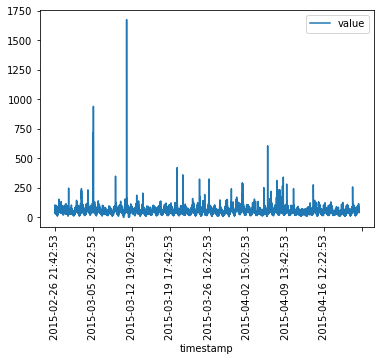

In [3]:
data.set_index('timestamp').plot()
plt.xticks(rotation='vertical')
plt.title("Plot the Original data")

Splitting the data into test and validation. We attempt to predict the next 5 values based on the previous 72 values (6 hours).

In [4]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):], y[:int(len(y)*0.9)], y[int(len(y)*0.9):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14247, 1), (14247, 1), (1583, 1), (1583, 1))

In [5]:
n_timesteps = 72
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
k=-5
batch_size=128
epochs=50


In [6]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples+1)]
X_train_list = X_train_list[:k]
X_train = np.concatenate(X_train_list, axis=0)
y_train_list = [np.expand_dims(y_train[i:i+5, :], axis=0) for i in range(n_timesteps, n_samples -5 + 1)]
y_train = np.concatenate(y_train_list, axis=0)
X_train = X_train[:-1, :, :]
y_train = y_train[1:, :, :]
# y_train = y_train[n_timesteps-1:, :]


X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val_list = X_val_list[:k]
X_val = np.concatenate(X_val_list, axis=0)
# y_val = y_val[n_timesteps-1:, :]
y_val_list = [np.expand_dims(y_val[i:i+5, :], axis=0) for i in range(n_timesteps, n_val_samples- 5 + 1)]
y_val = np.concatenate(y_val_list, axis=0)
X_val = X_val[:-1, :, :]
y_val = y_val[1:, :, :]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(14170, 72, 1) (14170, 5, 1) (1506, 72, 1) (1506, 5, 1)


In [7]:

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps,))
    
    # x = LSTM(50, return_sequences=True)(i)
    x = Dense(200, kernel_initializer='he_normal')(i)
    x = Dropout(0.4)(x)
    
    # x = LSTM(50)(x)
    x = Dense(200, kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)

    # x = LSTM(50)(x)
    # x = Dense(200, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    # x = Dense(200, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    x = Dense(5, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [8]:
model = Autoencoder(n_timesteps, 5)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               14600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
_________________________________________________________________
activation (Activation)      (None, 5)                

In [9]:
# model = Autoencoder(n_timesteps, 5)
# model.summary()
history = model.fit(x=X_train.squeeze(), y=y_train.squeeze(), batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
111/111 [==============================] - 0s 4ms/step - loss: 60.4821 - val_loss: 11.9193
Epoch 2/50
111/111 [==============================] - 0s 4ms/step - loss: 18.3815 - val_loss: 13.4576
Epoch 3/50
111/111 [==============================] - 0s 3ms/step - loss: 18.5731 - val_loss: 20.8403
Epoch 4/50
111/111 [==============================] - 0s 3ms/step - loss: 18.4427 - val_loss: 21.9280
Epoch 5/50
111/111 [==============================] - 0s 3ms/step - loss: 19.2173 - val_loss: 12.1583
Epoch 6/50
111/111 [==============================] - 0s 3ms/step - loss: 19.1196 - val_loss: 19.6569
Epoch 7/50
111/111 [==============================] - 0s 3ms/step - loss: 19.7204 - val_loss: 12.5641
Epoch 8/50
111/111 [==============================] - 0s 3ms/step - loss: 19.2461 - val_loss: 14.2582
Epoch 9/50
111/111 [==============================] - 0s 3ms/step - loss: 20.1442 - val_loss: 16.4364
Epoch 10/50
111/111 [==============================] - 0s 3ms/step - loss: 20.1756

In [10]:
y_train_pred = model.predict(X_train)

In [11]:
y_train_pred.shape

(14170, 5)

In [12]:
from sklearn.metrics import mean_absolute_error
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]


Since we have the list of errors, we plot to them to see how they are distributed.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Distribution of Errors')

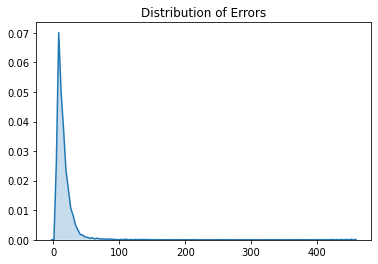

In [14]:
import seaborn as sb
sb.kdeplot(errors, shade=True)
plt.title("Distribution of Errors")

If the errors for each value of the data set were normally distributed, we can consider all values away that are beyond 1 standard deviation from the mean as anomaly. Hence, we are now fitting this data to a normal distribution.

In [15]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(15.645612844831943, 16.59118115420971)

We get the mean and standard deviation here. We can consider all the values that lie around 1 standard deviation away from the mean. Any value beyond this can be considered an anomaly. We can consider different ranges of error beyond which a value can be anomaly. We have chosen a range of 1 standard deviation from the mean to consider a value normal.

In [16]:
def is_anomaly(error, mean, std, threshold):
    difference = np.abs(error - mean)
    value = difference / std
    if value < threshold:
        return 0
    else:
        return 1

In [17]:
# MAE
y_val_pred = model.predict(X_val[:, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results = [is_anomaly(x, dist.mean(), dist.std(), 1) for x in val_errors]
print(results)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
#MSE
from sklearn.metrics import mean_squared_error
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
mse = [mean_squared_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results_mse = [is_anomaly(x, mean(mse), stdev(mse), 1) for x in mse]
print(results_mse)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
# R2 Score
from sklearn.metrics import r2_score
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
r2 = [r2_score(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results_r2 = [is_anomaly(x, mean(r2), stdev(r2), 1) for x in r2]
print(results_r2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)


result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]
print(result)

[0.5257, 0.5288, 0.582, 0.5809, 0.6937, 0.7187, 0.7501, 0.7205, 0.7461, 0.6225, 0.5305, 0.6757, 0.6923, 0.6942, 0.6561, 0.7226, 0.7194, 0.6397, 0.6135, 0.5455, 0.5224, 0.5205, 0.5762, 0.7033, 0.8011, 0.8905, 0.8425, 0.8045, 0.8224, 0.757, 0.827, 0.905, 0.9752, 0.9926, 0.9795, 0.9743, 0.8716, 0.7619, 0.5931, 0.7666, 0.6641, 0.6352, 0.7167, 0.6902, 0.5281, 0.5616, 0.6389, 0.6173, 0.5911, 0.5256, 0.5323, 0.5386, 0.6268, 0.7057, 0.5415, 0.5417, 0.7131, 0.7794, 0.7516, 0.6349, 0.5699, 0.7151, 0.6992, 0.7165, 0.7219, 0.7179, 0.6967, 0.5185, 0.525, 0.5407, 0.6348, 0.7164, 0.5246, 0.5892, 0.6766, 0.6435, 0.6474, 0.6963, 0.6948, 0.7413, 0.6181, 0.6556, 0.5873, 0.5784, 0.5279, 0.5829, 0.5911, 0.6364, 0.6233, 0.6159, 0.6473, 0.7356, 0.7378, 0.6216, 0.6363, 0.6377, 0.5169, 0.5893, 0.5964, 0.6136, 0.6147, 0.7037, 0.7196, 0.7725, 0.8639, 0.8556, 0.7833, 0.6755, 0.8549, 0.7999, 0.816, 0.8372, 0.8483, 0.7715, 0.704, 0.5532, 0.6422, 0.7083, 0.7709, 0.7924, 0.7801, 0.7443, 0.7274, 0.7128, 0.719, 0.6986,

In [21]:
f = []
for i in range(len(y_val)):
  f.append(y_val[i][0])


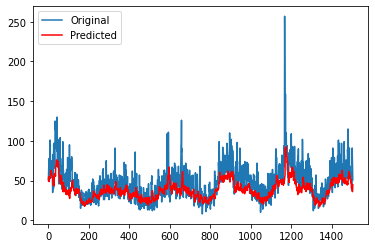

In [22]:
import matplotlib.pyplot as plt

plt.plot(y_val[:,0], label="Original")
plt.plot(y_val_pred[:,0],color="r", label="Predicted")
plt.legend()

The higher the number, the more likely the sample is to be an anomaly.

In [24]:
# For MAE plot
plot_x=[]
plot_y=[]
for i in range(len(results)): 
  if results[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

[array([40]), array([95]), array([66]), array([70]), array([125]), array([114]), array([115]), array([113]), array([95]), array([67]), array([68]), array([77]), array([32]), array([64]), array([109]), array([95]), array([71]), array([98]), array([58]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([73]), array([66]), array([69]), array([59]), array([86]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([83]), array([88]), array([105]), array([59]), array([65]), array([60]), array([53]), array([89]), array([102]), array([56]), array([89]), array([85]), array([85]), array([115])]


Text(0.5, 1.0, 'MAE Error Metric')

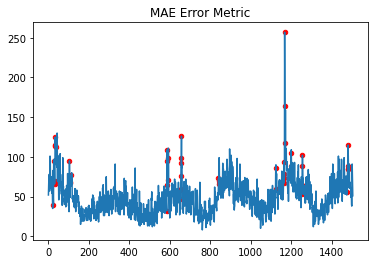

In [25]:
plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)
plt.title("MAE Error Metric")


In [26]:
# For MSE plot
plot_x=[]
plot_y=[]
for i in range(len(results_mse)): 
  if results_mse[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

[array([40]), array([95]), array([66]), array([70]), array([125]), array([114]), array([115]), array([113]), array([95]), array([67]), array([68]), array([77]), array([32]), array([64]), array([109]), array([95]), array([71]), array([98]), array([58]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([73]), array([66]), array([69]), array([59]), array([86]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([83]), array([88]), array([105]), array([59]), array([65]), array([60]), array([53]), array([89]), array([102]), array([56]), array([89]), array([85]), array([85]), array([115])]


Text(0.5, 1.0, 'MSE Error Metric')

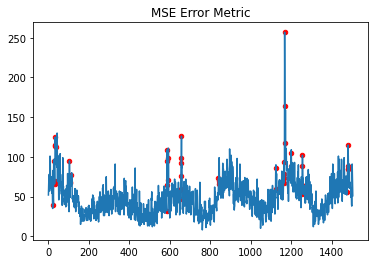

In [27]:
plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)
plt.title("MSE Error Metric")

[array([40]), array([95]), array([66]), array([70]), array([125]), array([114]), array([115]), array([113]), array([95]), array([67]), array([68]), array([77]), array([32]), array([64]), array([109]), array([95]), array([71]), array([98]), array([58]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([73]), array([66]), array([69]), array([59]), array([86]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([83]), array([88]), array([105]), array([59]), array([65]), array([60]), array([53]), array([89]), array([102]), array([56]), array([89]), array([85]), array([85]), array([115])]


Text(0.5, 1.0, 'R2 Score Metric')

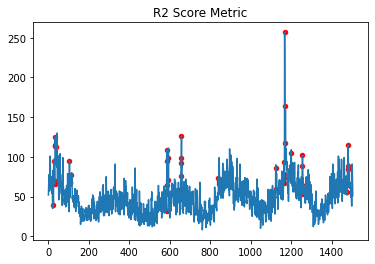

In [28]:
# For R2 plot
plot_x=[]
plot_y=[]
for i in range(len(results_r2)): 
  if results_r2[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r", s=20)
plt.title("R2 Score Metric")

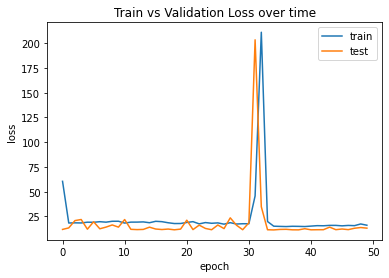

In [29]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')